In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()

def read_data(file_path):
    from pandas import read_csv
    series_influ_A_df = read_csv(file_path, index_col=0, engine='python')
    series_influ_A_df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})
    series_influ_A_df = series_influ_A_df[["case", "temp", "tempmax", "dew","windspeed"]]
    return series_influ_A_df.dropna()

def prepare_data(series, n_test, look_back, scaler, is_ema = False):
    if is_ema:
        span = 52  # Bạn có thể điều chỉnh độ dài span tùy ý
        series['case'] = exponential_moving_average(series['case'], span)
    series = series.astype('float32')
    series = series.values
    dataset = scaler.fit_transform(series)
    train = dataset[:-n_test, :]
    test = dataset[-n_test-look_back:, :]
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    return trainX, trainY, testX, testY



In [5]:
df = read_data('../temp_data/influA_vietnam_last_10_days.csv')
look_back =15
test_size = 50
trainX, trainY, testX, testY = prepare_data(df, test_size, look_back, scaler, is_ema=True)


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU


model = Sequential([
    GRU(units=64, activation='relu', input_shape=(look_back,5)),
    #  Dense(units=32, activation='relu'),
    #   Dense(units=16, activation='relu'),
    Dense(units=5, activation='sigmoid' )
])

# # Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, validation_data=(testX, testY))

Epoch 1/100


d:\my_study\gr3\DATN\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


726/726 - 3s - 5ms/step - loss: 0.0254 - val_loss: 0.0104
Epoch 2/100
726/726 - 2s - 3ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 3/100
726/726 - 2s - 3ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 4/100
726/726 - 2s - 3ms/step - loss: 0.0096 - val_loss: 0.0114
Epoch 5/100
726/726 - 2s - 3ms/step - loss: 0.0093 - val_loss: 0.0108
Epoch 6/100
726/726 - 2s - 3ms/step - loss: 0.0089 - val_loss: 0.0104
Epoch 7/100
726/726 - 2s - 3ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 8/100
726/726 - 2s - 3ms/step - loss: 0.0083 - val_loss: 0.0103
Epoch 9/100
726/726 - 2s - 3ms/step - loss: 0.0082 - val_loss: 0.0097
Epoch 10/100
726/726 - 2s - 3ms/step - loss: 0.0081 - val_loss: 0.0093
Epoch 11/100
726/726 - 2s - 3ms/step - loss: 0.0081 - val_loss: 0.0099
Epoch 12/100
726/726 - 2s - 3ms/step - loss: 0.0078 - val_loss: 0.0096
Epoch 13/100
726/726 - 2s - 3ms/step - loss: 0.0079 - val_loss: 0.0091
Epoch 14/100
726/726 - 2s - 3ms/step - loss: 0.0077 - val_loss: 0.0094
Epoch 15/100
726/726 - 2s -

In [6]:
def forecast(input, model):
    input = input.reshape(1, input.shape[0], input.shape[1])
    predicted = model.predict(input, verbose=0)
    return predicted[0]

def make_forecasts(test, model):
    forecasts = []
    inputStart = test[0]
    inputX = inputStart.reshape(1, inputStart.shape[0], inputStart.shape[1])
    for i in range(len(test)):
        predicted = forecast(inputX[i], model)
        forecasts.append(predicted)
        inputXContinue = np.vstack((inputX[-1][1:], predicted))
        inputX = np.append(inputX, [inputXContinue], axis=0)
    
    return forecasts

def evaluate_forecasts(test, forecasts):
    from sklearn.metrics import mean_squared_error
    testScore = np.sqrt(mean_squared_error(test, forecasts))
    print('Test Score: %.2f RMSE' % (testScore))

In [7]:
forecasts = make_forecasts(testX, model)
# invert predictions
forecasts = scaler.inverse_transform(forecasts)
testY_ = scaler.inverse_transform(testY)
evaluate_forecasts(testY_[:,0].reshape(-1), forecasts[:, 0].reshape(-1))

Test Score: 5.41 RMSE


In [8]:
def plot(testY, forecasts):
    import matplotlib.pyplot as plt
    forecastsPlot = np.empty([forecasts.shape[0]])
    forecastsPlot[:] = np.nan
    forecastsPlot[:] = forecasts[:,0].reshape(-1)
    testPlot = np.empty([testY.shape[0]])
    testPlot[:] = np.nan
    testPlot[:] = testY[:,0].reshape(-1)
    plt.plot(testPlot, "-y", label="actual", marker= '.')
    plt.plot(forecastsPlot, color = 'green', label="forecast", marker='x')
    plt.ylabel("Number of infections")
    plt.legend(["actual", "forecast"])
    plt.show()


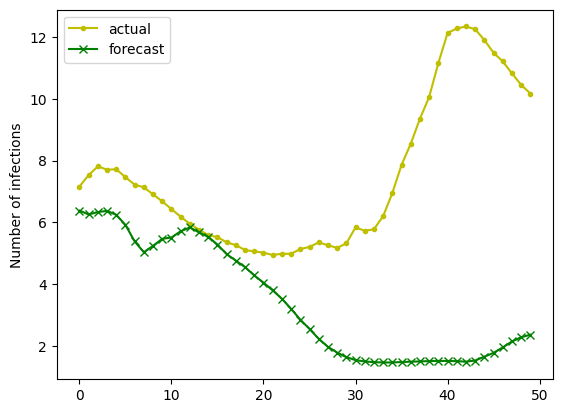

In [9]:
plot(testY_, forecasts)

In [15]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
param_grid = {
    'look_back': [1, 3, 5, 7, 10]
}

model = KerasRegressor(model=model)
print(model.get_params().keys())
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     # cv=tss,
#     scoring='neg_mean_squared_error',
#     verbose=1,
#     n_jobs=-1
# )

# grid_search.fit(trainX, trainY)

dict_keys(['model__model', 'model__build_fn', 'model__warm_start', 'model__random_state', 'model__optimizer', 'model__loss', 'model__metrics', 'model__batch_size', 'model__validation_batch_size', 'model__verbose', 'model__callbacks', 'model__validation_split', 'model__shuffle', 'model__run_eagerly', 'model__epochs', 'model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])


In [52]:
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU

class MyGRU (Sequential):
    def __init__(self, series, look_back, test_size, scaler, epochs, is_ema=True, dense_units =[],unit=64, optimizer='adam',name='gru'):
        super().__init__(name=name)
        self.look_back = look_back
        self.epochs = epochs
        self.add(GRU(units=unit, activation='relu', input_shape=(look_back,5)))
        for unit in dense_units:
            self.add(Dense(units=unit, activation='relu'))
        self.add(Dense(units=5, activation='sigmoid' ))
        self.compile(optimizer=optimizer, loss='mean_squared_error')
        self.trainX, self.trainY, self.testX, self.testY = prepare_data(series, test_size, look_back, scaler, is_ema=True)
    
    def exponential_moving_average(data, span):
        return data.ewm(span=span, adjust=False).mean()
    
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back):
            a = dataset[i:(i+look_back)]
            dataX.append(a)
            dataY.append(dataset[i + look_back])
        return np.array(dataX), np.array(dataY)
    
    def prepare_data(series, n_test, look_back, scaler, is_ema = False):
        if is_ema:
            span = 52  # Bạn có thể điều chỉnh độ dài span tùy ý
            series['case'] = exponential_moving_average(series['case'], span)
        series = series.astype('float32')
        series = series.values
        dataset = scaler.fit_transform(series)
        train = dataset[:-n_test, :]
        test = dataset[-n_test-look_back:, :]
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)
        return trainX, trainY, testX, testY
    
    def forecast(self, input):
        input = input.reshape(1, input.shape[0], input.shape[1])
        predicted = self.predict(input, verbose=0)
        return predicted[0]
    
    def fit(self):
        super().fit(self.trainX, self.trainY, epochs=self.epochs, batch_size=1, verbose=2, validation_data=(self.testX, self.testY))


In [54]:
# class MyClass:
#     def __init__(self, param1, param2):
#         self.param1 = param1
#         self.param2 = param2
#         self.sum = self.method1()

#     def method1(self):
#         return self.param1 + self.param2

# # Create an instance of the class
# obj = MyClass(10, 20)
# print(obj.sum)

model = MyGRU(df,look_back, test_size, scaler, 50)
# model = KerasRegressor(model=model)
# print(model.get_params().keys())
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     # cv=tss,
#     scoring='neg_mean_squared_error',
#     verbose=1,
#     n_jobs=-1
# )
# grid_search.fit(trainX, trainY)
model.fit()

Epoch 1/50


d:\my_study\gr3\DATN\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


726/726 - 3s - 5ms/step - loss: 0.0294 - val_loss: 0.0138
Epoch 2/50
726/726 - 2s - 3ms/step - loss: 0.0109 - val_loss: 0.0099
Epoch 3/50
726/726 - 2s - 3ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 4/50
726/726 - 2s - 3ms/step - loss: 0.0093 - val_loss: 0.0105
Epoch 5/50
726/726 - 2s - 3ms/step - loss: 0.0090 - val_loss: 0.0107
Epoch 6/50
726/726 - 2s - 3ms/step - loss: 0.0088 - val_loss: 0.0115
Epoch 7/50
726/726 - 2s - 3ms/step - loss: 0.0085 - val_loss: 0.0098
Epoch 8/50
726/726 - 2s - 3ms/step - loss: 0.0081 - val_loss: 0.0099
Epoch 9/50
726/726 - 2s - 3ms/step - loss: 0.0079 - val_loss: 0.0091
Epoch 10/50
726/726 - 2s - 3ms/step - loss: 0.0080 - val_loss: 0.0114
Epoch 11/50
726/726 - 2s - 3ms/step - loss: 0.0079 - val_loss: 0.0097
Epoch 12/50
726/726 - 2s - 3ms/step - loss: 0.0077 - val_loss: 0.0090
Epoch 13/50
726/726 - 2s - 3ms/step - loss: 0.0078 - val_loss: 0.0091
Epoch 14/50
726/726 - 2s - 3ms/step - loss: 0.0076 - val_loss: 0.0092
Epoch 15/50
726/726 - 2s - 3ms/step - lo

In [55]:
def custom_make_forecasts(test, model):
    forecasts = []
    inputStart = test[0]
    inputX = inputStart.reshape(1, inputStart.shape[0], inputStart.shape[1])
    for i in range(len(test)):
        predicted = model.forecast(inputX[i])
        forecasts.append(predicted)
        inputXContinue = np.vstack((inputX[-1][1:], predicted))
        inputX = np.append(inputX, [inputXContinue], axis=0)
    
    return forecasts

forecasts = custom_make_forecasts(testX, model)

In [56]:
forecasts = scaler.inverse_transform(forecasts)
evaluate_forecasts(testY_[:,0].reshape(-1), forecasts[:, 0].reshape(-1))

Test Score: 4.94 RMSE


In [58]:
# model = KerasRegressor(model=model)
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     # cv=tss,
#     scoring='neg_mean_squared_error',
#     verbose=1,
#     n_jobs=-1
# )
# grid_search.fit(trainX, trainY)
print(model.get_params().keys())

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])
